For batch experiments, constant aeration  
MLSS: $$\frac{dMLSS}{dt} = \mu*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS-kd*MLSS$$  
BOD: $$\frac{dBOD}{dt} = -\frac{\mu}{Y}*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS$$
DO: $$\frac{dDO}{dt} = -\frac{\mu}{Y}*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS+K_{L}a*(CS-DO)$$

In [17]:
import numpy as np
import matplotlib.pyplot as plt

#kbod, BOD saturation constant, mg/L
kbod=20
#ko2,oxygen saturation constant, mg/L
ko2=0.1
#Y, growth yield coefficient, g cell/g BOD
Y=1.1
#µ, maximum gross growth rate,/day
µ=6
#kd, death rate,/day
kd=0.1
#kla,/day
kla=400
#CS,Saturated DO concentration,mg/L
CS=9

# Initial condition
initialMLSS=100
initialBOD=300
initialDO=8.25

#Reaction time,200min
T=200/24/60
#delt,1min
delt=1/24/60
n=int(T/delt)
timerange = np.linspace(0,T,n)
print(n)

conc=np.zeros(shape=(1,3))
conc[0]=[initialMLSS,initialBOD,initialDO]


i=0
while i<n-1:
#concentration changes by microorganisms reactionin delt
    delreac=delt*np.array([µ*(conc[i,1]/(kbod+conc[i,1]))*(conc[i,2]/(ko2+conc[i,2]))*conc[i,0]-kd*conc[i,0],
                      -µ/Y*(conc[i,1]/(kbod+conc[i,1]))*(conc[i,2]/(ko2+conc[i,2]))*conc[i,0],
                      -µ/Y*(conc[i,1]/(kbod+conc[i,1]))*(conc[i,2]/(ko2+conc[i,2]))*conc[i,0]])
#DO concentration changes by aerotion.
    delaero=delt*np.array([0,0,kla*(CS-conc[i,2])])
    delconc=np.sum([delaero,delreac],axis=0)
    conc= np.row_stack((conc,conc[i]+delconc))
    i=i+1
print(conc.shape)
    

200
(200, 3)


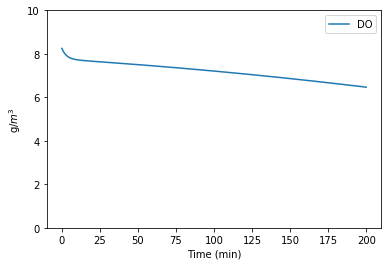

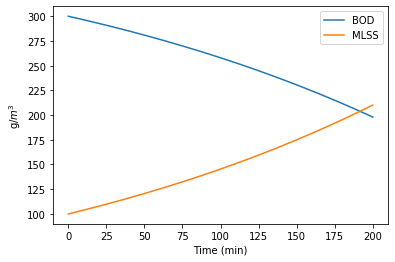

After 0.1388888888888889 days operation
DO = 6.467655558582406
BOD = 198.04238766952852
MLSS= 210.10352091262385


In [18]:
plt.figure(1)
line = plt.plot(24*60*timerange, np.array(conc[:,2]), '-', label='DO')
plt.ylim([0,10])
plt.legend()
plt.ylabel('g/$m^3$')
plt.xlabel('Time (min)')
plt.show()
plt.figure(2)
line1 = plt.plot(24*60*timerange, np.array(conc[:,1]), '-', label='BOD')
line2 = plt.plot(24*60*timerange, np.array(conc[:,0]), '-', label='MLSS')
plt.legend()
plt.ylabel('g/$m^3$')
plt.xlabel('Time (min)')
plt.show()
print('After',T,'days operation')
print('DO =',conc[-1][2])
print('BOD =',conc[-1][1])
print('MLSS=',conc[-1][0])

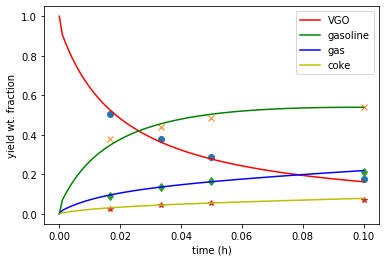

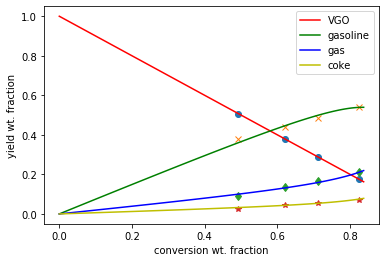

K12 = 38.52204233730372
K13 = 9.877905868525396
K14 = 3.101404781871807
K23 = 1.3133238368194406
K24 = 0.633607673490654


In [19]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Data
xaxisData = np.array( [1/60, 1/30, 1/20, 1/10] ) # time 
yaxisData = np.array( [ [0.5074, 0.3796, 0.2882,0.1762], [0.3767, 0.4385, 0.4865, 0.5416], [0.0885, 0.136,0.1681 ,0.2108], [0.0274,0.0459, 0.0572, 0.0714]] )
conversion = np.array( [0.4926, 0.6204, 0.7118, 0.8238] )
# Guesses for parameters 
k12guess = 0.1; 
k13guess = 0.1; 
k14guess = 0.1; 
k23guess = 0.1; 
k24guess = 0.1; 
parameterGuesses = np.array([k12guess,k13guess,k14guess,k23guess,k24guess])

#Define ODEs 
def ODE_definition(y,t,args): 
    y1 = y[0]
    y2 = y[1]
    y3 = y[2]
    y4 = y[3]
    k12 = args[0]
    k13 = args[1]
    k14 = args[2]
    k23 = args[3]
    k24 = args[4]
    dy1dt = -(k12+k13+k14)*y1**2
    dy2dt = k12*y1**2 - k23*y2 - k24*y2
    dy3dt = k13*y1**2 + k23*y2
    dy4dt = k14*y1**2 + k24*y2
    return dy1dt, dy2dt, dy3dt, dy4dt
 
def ODEmodel(xaxisData,*params):
    yaxis0 = np.array([1,0,0,0])
    numYaxisVariables = 4 
    yaxisOutput = np.zeros((xaxisData.size,numYaxisVariables)) 
    for i in np.arange(0,len(xaxisData)):
        xaxisIncrement = 0.001 
        xaxisSpan = np.arange(0,xaxisData[i]+xaxisIncrement,xaxisIncrement)
        y_calc = odeint(ODE_definition,yaxis0,xaxisSpan,args=(params,))
        yaxisOutput[i,:]=y_calc[-1,:]
        
    yaxisOutput = np.transpose(yaxisOutput)
    yaxisOutput = np.ravel(yaxisOutput)
    return yaxisOutput

parametersoln, pcov = curve_fit(ODEmodel,xaxisData,np.ravel(yaxisData),p0=parameterGuesses)


plt.figure(1)
plt.plot(xaxisData, yaxisData[0,:],'o') 
plt.plot(xaxisData, yaxisData[1,:],'x') 
plt.plot(xaxisData, yaxisData[2,:],'d')
plt.plot(xaxisData, yaxisData[3,:],'*')
yaxis0 = np.array([100,1])
numYaxisVariables = 4
xforPlotting = np.linspace(0,xaxisData[-1],100) 
y_calculated = ODEmodel(xforPlotting,*parametersoln)
y_calculated = np.reshape(y_calculated,(numYaxisVariables,xforPlotting.size))
line1 =plt.plot(xforPlotting, y_calculated[0,:],'r-',label='VGO') 
line2 =plt.plot(xforPlotting, y_calculated[1,:],'g-',label='gasoline') 
line3 =plt.plot(xforPlotting, y_calculated[2,:],'b-',label='gas') 
line4 =plt.plot(xforPlotting, y_calculated[3,:],'y-',label='coke')
plt.xlabel('time (h)')
plt.ylabel('yield wt. fraction')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(conversion, yaxisData[0,:],'o') 
plt.plot(conversion, yaxisData[1,:],'x') 
plt.plot(conversion, yaxisData[2,:],'d')
plt.plot(conversion, yaxisData[3,:],'*')
yaxis0 = np.array([100,1])
numYaxisVariables = 4
xforPlotting = np.linspace(0,xaxisData[-1],100) 
y_calculated = ODEmodel(xforPlotting,*parametersoln)
y_calculated = np.reshape(y_calculated,(numYaxisVariables,xforPlotting.size))
line1 =plt.plot(1-y_calculated[0,:], y_calculated[0,:],'r-',label='VGO') 
line2 =plt.plot(1-y_calculated[0,:], y_calculated[1,:],'g-',label='gasoline') 
line3 =plt.plot(1-y_calculated[0,:], y_calculated[2,:],'b-',label='gas') 
line4 =plt.plot(1-y_calculated[0,:], y_calculated[3,:],'y-',label='coke')
plt.xlabel('conversion wt. fraction')
plt.ylabel('yield wt. fraction')
plt.legend()
plt.show()

print('K12 =',parametersoln[0])
print('K13 =',parametersoln[1])
print('K14 =',parametersoln[2])
print('K23 =',parametersoln[3])
print('K24 =',parametersoln[4])